# Protocol: Comparing Models by their BFS Frontiers: Relative and Absolute

Date: 17.09.2021

## Question

Do different models affect the BFS frontiers in terms of visited and failed states differently throughout the search of a single VT?

## Hypothesis

Each BFS starts with a single initial state, then quickly discovers a lot new visited states until the number of failed states takes over due to the hash table filling up. Approximately this curve should be visible in the BFS frontier of each BFS round.

## Setup

- GPU: NVIDIA GeForce RTX 2080 Ti
- Program: `main` branch, commit 755ef1d
- Models: Waypoints, Philosophers, Anderson, Peterson
- CUDA_FLAGS: `-DGRAPPLE_INSPECT_BFS`

## Implementation

Due to the `-DGRAPPLE_INSPECT_BFS` CUDA_FLAGS, only a single VT is executed.

First, we inspect the Waypoints model and thus add the additional CUDA_FLAGS `-DGRAPPLE_MODEL=WaypointsState`.

```
$ time ./build/grapple -s 1736331306 -n 1

real    0m0.470s
user    0m0.162s
sys     0m0.162s
```

Full output data is available at [EXP-11-bfs-frontiers-1.csv](./data/EXP-11-bfs-frontiers-1.csv).

--

Second experiment, we inspect the Philosophers model and thus add the additional CUDA_FLAGS `-DGRAPPLE_MODEL=PhilosophersStateV2`.

```
$ time ./build/grapple -s 1736331306 -n 1

real    0m0.618s
user    0m0.335s
sys     0m0.171s
```

Full output data is available at [EXP-11-bfs-frontiers-2.csv](./data/EXP-11-bfs-frontiers-2.csv).

---

Third experiment, we inspect `-DGRAPPLE_MODEL=AndersonState`.

```
$ time ./build/grapple -s 1736331306 -n 1

real    0m0.469s
user    0m0.213s
sys     0m0.189s
```

Full output data is available at [EXP-11-bfs-frontiers-3.csv](./data/EXP-11-bfs-frontiers-3.csv).

---

Fourth experiment, we inspect `-DGRAPPLE_MODEL=PetersonState`.

```
$ time ./build/grapple -s 1736331306 -n 1

real    0m0.556s
user    0m0.236s
sys     0m0.196s
```

Full output data is available at [EXP-11-bfs-frontiers-4.csv](./data/EXP-11-bfs-frontiers-4.csv).

## Evaluation

First, we evaluate the absolute numbers of visited and failed states for each model:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("presentation.mplstyle")

e1 = pd.read_csv("data/EXP-11-bfs-frontiers-1.csv", skipinitialspace=True)
e2 = pd.read_csv("data/EXP-11-bfs-frontiers-2.csv", skipinitialspace=True)
e3 = pd.read_csv("data/EXP-11-bfs-frontiers-3.csv", skipinitialspace=True)
e4 = pd.read_csv("data/EXP-11-bfs-frontiers-4.csv", skipinitialspace=True)

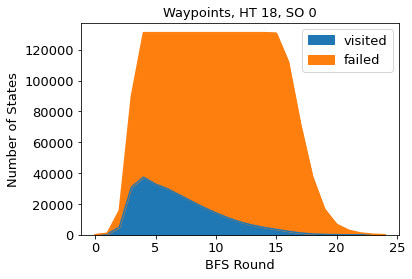

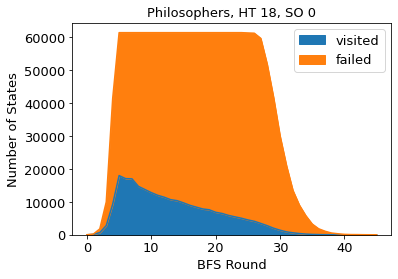

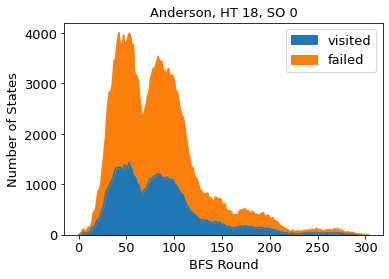

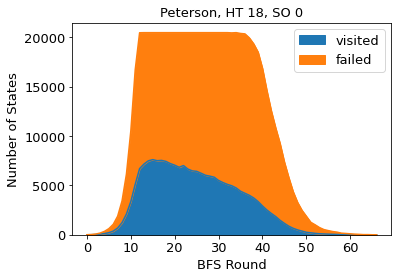

In [2]:
def plot_absolute(data, title, output_filename):
    pp = data.plot(y=["visited", "failed"], kind="area", xlabel="BFS Round", ylabel="Number of States", title=title)
    pp.get_figure().savefig(output_filename)

plot_absolute(e1, "Waypoints, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-1.pdf")
plot_absolute(e2, "Philosophers, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-2.pdf")
plot_absolute(e3, "Anderson, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-3.pdf")
plot_absolute(e4, "Peterson, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-4.pdf")

Then, we evaluate visited and failed states relative.

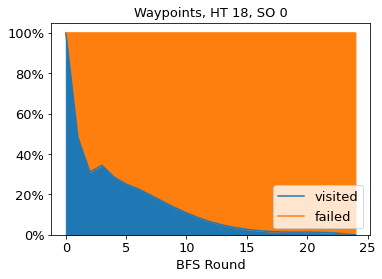

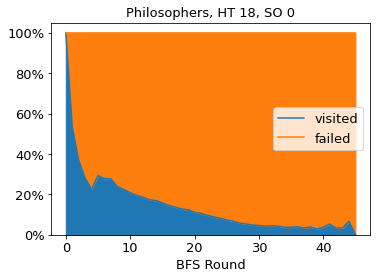

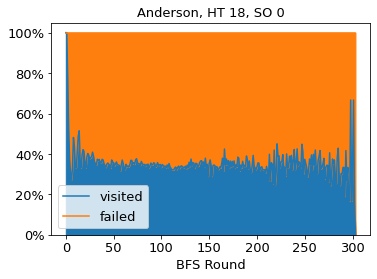

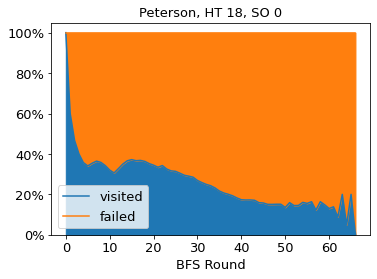

In [3]:
import matplotlib.ticker as mtick

def plot_relative(data, title, output_filename):
    data["rel_visited"] = data["visited"] / (data["visited"] + data["failed"]) * 100
    data["rel_failed"] = data["failed"] / (data["visited"] + data["failed"]) * 100
    pp = data.plot(y=["rel_visited", "rel_failed"], kind="area", xlabel="BFS Round", title=title)
    # pp.axhline(y=data["rel_visited"].median(), color="red")
    pp.yaxis.set_major_formatter(mtick.PercentFormatter())
    pp.legend(["visited", "failed"])

    pp.get_figure().savefig(output_filename)

plot_relative(e1, "Waypoints, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-5.pdf")
plot_relative(e2, "Philosophers, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-6.pdf")
plot_relative(e3, "Anderson, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-7.pdf")
plot_relative(e4, "Peterson, HT 18, SO 0", "output-assets/EXP-11-bfs-frontiers-8.pdf")

To further investigate the notch in the absolute visited/failed plot of the Anderson model, we log internal states of the Anderson model for each BFS round.

This experiment is executed using a modified Setup:

- Program: `feature/EXP-11-anderson-state-logging` branch, commit 61537a5
- CUDA_FLAGS: `-DGRAPPLE_MODEL=AndersonState -DGRAPPLE_INSPECT_BFS`

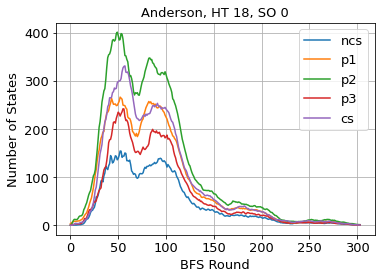

In [4]:
e5 = pd.read_csv("data/EXP-11-bfs-frontiers-5.csv", skipinitialspace=True)
for state in ["ncs", "p1", "p2", "p3", "cs"]:
    e5[state] = e5[state].ewm(span=10).mean()
pp = e5.plot(y=["ncs", "p1", "p2", "p3", "cs"], xlabel="BFS Round", ylabel="Number of States", title="Anderson, HT 18, SO 0", grid=True)
pp.get_figure().savefig("output-assets/EXP-11-bfs-frontiers-9.pdf")


## Conclusion, Discussion

- Why do Waypoints, Philosophers and Peterson have an upper limit on the sum of visited and failed states?
- Why does the Anderson model has a notch in the absolute plot?
- Why is the Anderson model nearly linear in the relative plot, ending with a sharp edge to zero?
- Can we observe whether a model is generally linear / has bottlenecks from the plots?
